# Skyline Hospital Time Series Forecasting with XGBoost Solution 2

## Import Required Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import pyarrow

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# Plot aesthetics
color_pal = sns.color_palette()
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb  # ML algorithm for forecasting
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Error metrics

## Load the Data

In [2]:
filepath = 'data/skyline_hospital_bill_charge_report.csv'

df = pd.read_csv(filepath)
df

Open Date  Bill No.      Charge Head Doctor Code  Qty
0       2020-05-18  BL427653  OP Consultation     DOC0114    1
1       2020-05-18  BL427654  OP Consultation     DOC0114    1
2       2020-05-18  BL427655  OP Consultation     DOC0207    1
3       2020-05-18  BL427656  OP Consultation     DOC0114    1
4       2020-05-18  BL427657  OP Consultation     DOC0114    1
...            ...       ...              ...         ...  ...
126152  2022-12-31  BL678528  OP Consultation     DOC0553    1
126153  2022-12-31  BL678529  OP Consultation     DOC0207    1
126154  2022-12-31  BL678530  OP Consultation     DOC0114    1
126155  2022-12-31  BL678531  OP Consultation     DOC0114    1
126156  2022-12-31  BL678535  OP Consultation     DOC0207    1

[126157 rows x 5 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126157 entries, 0 to 126156
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Open Date    126157 non-null  object
 1   Bill No.     126157 non-null  object
 2   Charge Head  126157 non-null  object
 3   Doctor Code  126157 non-null  object
 4   Qty          126157 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 4.8+ MB


The dataset is a bill charge report from Skyline Hospital and Medical Center's outpatient unit. It lists down **outpatient consultations from 2020-05-18 to 2022-12-31**, providing us with **2 years, 7 months, and 14 days** worth of outpatient consultations.

It can be seen that the number of observations is large. There are 126,157 observations (rows) and 5 variables (columns). The column names include: `'Bill No.'`, `'Open Date'`, `'Charge Head'`, `'Doctor Code'`, and `'Qty`.

## Data Cleaning

For time series forecasting, only the dates (`Open Date`) and the count of outpatient consultations (`Qty`) shall be used. Therefore, the 3 remaining columns are to be dropped, which will make this a time series data.

To make the columns more understandable, we can rename `'Open Date'` as `'Date'` and `'Qty'` as `'Patients'`, representing the number of patients for each date.

In [4]:
df = df[['Open Date', 'Qty']]
df = df.rename(columns={'Open Date': 'Date', 'Qty': 'Patients'})
df

Date  Patients
0       2020-05-18         1
1       2020-05-18         1
2       2020-05-18         1
3       2020-05-18         1
4       2020-05-18         1
...            ...       ...
126152  2022-12-31         1
126153  2022-12-31         1
126154  2022-12-31         1
126155  2022-12-31         1
126156  2022-12-31         1

[126157 rows x 2 columns]

We can see that the `'Date'` column is read with an `object` data type. We must change this to the pandas `datetime` format using `to_datetime()`. This will allow us to truly perceive it as time data, and use appropriate `datetime` functions for it.

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date        datetime64[ns]
Patients             int64
dtype: object

Having a closer look at our time series data lets us know that we have duplicated dates, and the **patient arrival counts are not summed up in one date** or instance. This is why we have more observations (rows) than what is expected. An easy fix for this would be to use `groupby()` on the `'Date'` column with the `sum()` method on the `'Patients'` column.

In [6]:
df = df.groupby(by='Date', as_index=False)['Patients'].sum()

In [7]:
df

Date  Patients
0   2020-05-18        67
1   2020-05-19        75
2   2020-05-20        74
3   2020-05-21        55
4   2020-05-22        62
..         ...       ...
851 2022-12-27       114
852 2022-12-28       156
853 2022-12-29       105
854 2022-12-30        24
855 2022-12-31        23

[856 rows x 2 columns]

Now we can be sure that **there are no more duplicated dates**.

In [8]:
df[df['Date'].duplicated()]

Empty DataFrame
Columns: [Date, Patients]
Index: []

In [9]:
df.dtypes

Date        datetime64[ns]
Patients             int64
dtype: object

Since this seems to be cleaned enough data, we can save the time series data that was once a csv file, into a **parquet file**. This would allow us to **reduce memory consumption**.                                  

In [10]:
df.to_parquet('data/patient_arrivals.parquet')

Let's load and read the data once again.

In [11]:
parquet_file = 'data/patient_arrivals.parquet'
df = pd.read_parquet(parquet_file, engine='pyarrow')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      856 non-null    datetime64[ns]
 1   Patients  856 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.5 KB


A convention with time series data is to set the `datetime` column into an index.

In [13]:
df = df.set_index('Date')
df

Patients
Date                
2020-05-18        67
2020-05-19        75
2020-05-20        74
2020-05-21        55
2020-05-22        62
...              ...
2022-12-27       114
2022-12-28       156
2022-12-29       105
2022-12-30        24
2022-12-31        23

[856 rows x 1 columns]

Now we can see that the duplicated dates issue on the data is fixed, and has significantly **reduced the number of observations from 126,157 to just 856**. But this poses another issue. If we convert 2 years, 7 months, and 14 days into just the number of days, **we should be getting 958 days/rows**. Let's **define the date range for this so that we can have the true number of days from 2020-05-18 to 2022-12-31**.

In [14]:
new_index = pd.date_range(start='2020-05-18', end='2022-12-31', freq='D')
df = df.reindex(new_index)
df.index.name = 'Date'
df

Patients
Date                
2020-05-18      67.0
2020-05-19      75.0
2020-05-20      74.0
2020-05-21      55.0
2020-05-22      62.0
...              ...
2022-12-27     114.0
2022-12-28     156.0
2022-12-29     105.0
2022-12-30      24.0
2022-12-31      23.0

[958 rows x 1 columns]

## Visualize the Data

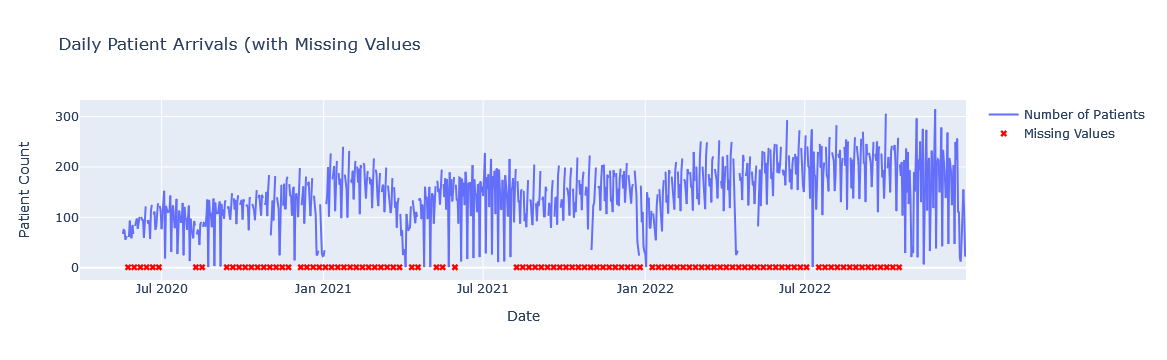

In [15]:
fig = go.Figure()

# Add scatter trace for patients
fig.add_trace(go.Scatter(x=df.index, y=df['Patients'], 
                          mode='lines', 
                          name='Number of Patients'))

# Add markers for missing values
missing_dates = df[df['Patients'].isna()].index
missing_values_trace = go.Scatter(x=missing_dates, y=[df['Patients'].min()]*len(missing_dates),
                                  mode='markers', marker=dict(color='red', symbol='x'),
                                  name='Missing Values')
fig.add_trace(missing_values_trace)

# Set plot title and axis labels
fig.update_layout(title='Daily Patient Arrivals (with Missing Values',
                  xaxis_title='Date', yaxis_title='Patient Count')

# Show plot
fig.show()

In [16]:
missing_vals = df[df['Patients'].isna()]
missing_vals

Patients
Date                
2020-05-24       NaN
2020-05-31       NaN
2020-06-07       NaN
2020-06-14       NaN
2020-06-21       NaN
...              ...
2022-09-18       NaN
2022-09-25       NaN
2022-10-02       NaN
2022-10-09       NaN
2022-10-16       NaN

[102 rows x 1 columns]

We can see **102 missing instances** of patient arrival counts. To see the pattern of missing values, we can add a time series feature to identify which days of the week are the missing values coming from.

In [17]:
df = df.copy()
df['date'] = df.index
df['day_of_week'] = df['date'].dt.dayofweek
df.head()

Patients       date  day_of_week
Date                                        
2020-05-18      67.0 2020-05-18            0
2020-05-19      75.0 2020-05-19            1
2020-05-20      74.0 2020-05-20            2
2020-05-21      55.0 2020-05-21            3
2020-05-22      62.0 2020-05-22            4

The week numbers in the `'day_of_week'` here could be perceived as:

- `0` : `Monday`
- `1` : `Tuesday`
- `2` : `Wednesday`
- `3` : `Thursday`
- `4` : `Friday`
- `5` : `Saturday`
- `6` : `Sunday`


In [18]:
patient_counts_by_week = df.groupby('day_of_week')[['Patients']].sum()
patient_counts_by_week

Patients
day_of_week          
0             22662.0
1             20406.0
2             21163.0
3             14423.0
4             21794.0
5             25108.0
6               601.0

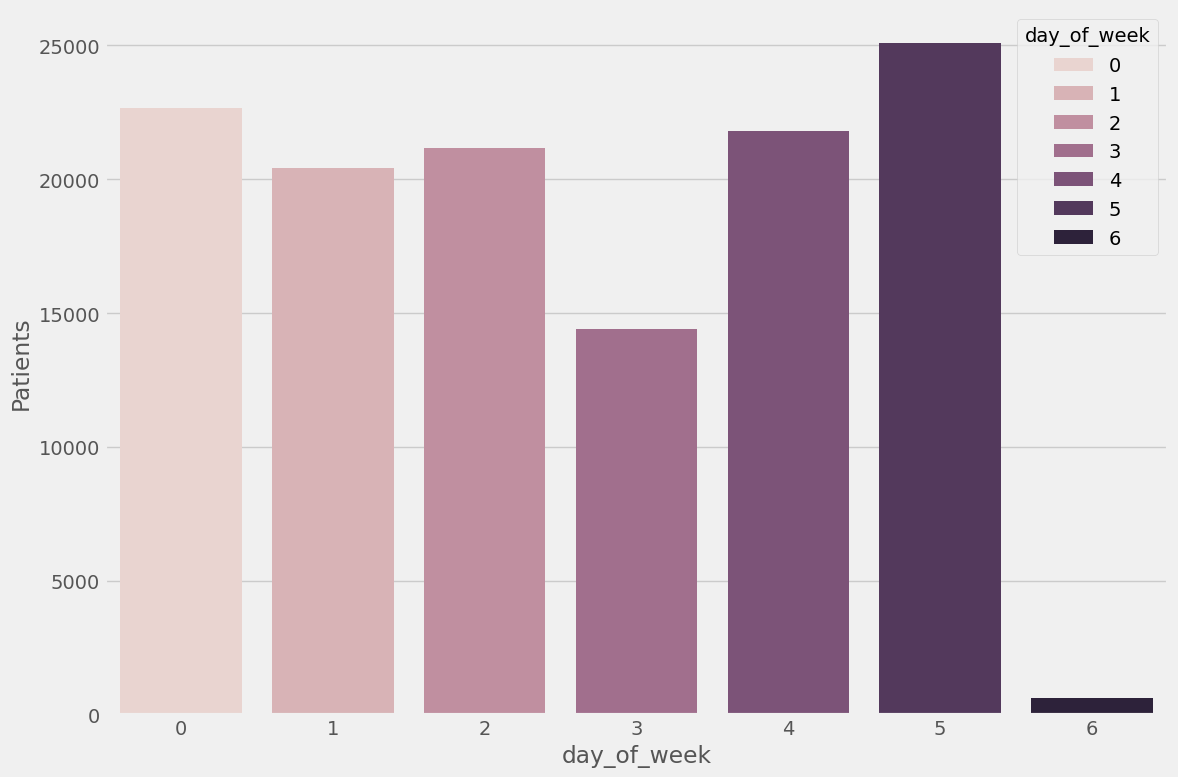

In [19]:
plt.figure(figsize=(12, 8))

sns.barplot(data=patient_counts_by_week, x='day_of_week', y='Patients', hue='day_of_week')

plt.tight_layout()
plt.show()

**Saturday** seems to be the day of the week with the **highest patient arrival counts**. Consequently, **Sunday** seems to be the one with the **lowest patient arrival counts**. What could this possibly mean?

![https://www.facebook.com/SkylineHospitalAndMedicalCenter/photos/a.944515819031784/1924894020993954/](./pictures/opening_now_on_sundays.jpg)

**Source:** [Facebook](https://www.facebook.com/SkylineHospitalAndMedicalCenter/photos/a.944515819031784/1924894020993954/)

Skyline Hospital and Medical Center has announced that starting on June 13, 2021, the outpatient unit will start to be active. This may explain why there seems to be a **weekly pattern of missing values during Sundays**, and that it seems to be the day of the week with the lowest count of patient arrival counts.

However, this would not explain why **there still seems to be Sundays with missing values**. As a solution to impute missing values, we can choose to **interpolate** it to estimate the number of patient arrival counts.

In [20]:
df = df.interpolate(method='linear')

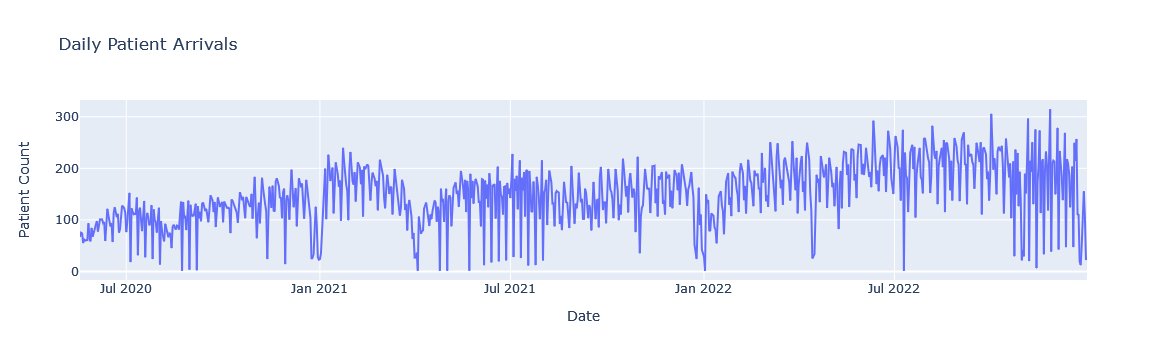

In [21]:
fig = go.Figure()

# Add scatter trace for patients
fig.add_trace(go.Scatter(x=df.index, y=df['Patients'], 
                          mode='lines', 
                          name='Number of Patients'))

# Add markers for missing values
missing_dates = df[df['Patients'].isna()].index
missing_values_trace = go.Scatter(x=missing_dates, y=[df['Patients'].min()]*len(missing_dates),
                                  mode='markers', marker=dict(color='red', symbol='x'),
                                  name='Missing Values')
fig.add_trace(missing_values_trace)

# Set plot title and axis labels
fig.update_layout(title='Daily Patient Arrivals',
                  xaxis_title='Date', yaxis_title='Patient Count')

# Show plot
fig.show()

Now we have eliminated the issue of missing values. Let's proceed to **decompose** our time series data.

## Time Series Decomposition

We can try to decompose the time series data to know its **trend, seasonality, and residual** components.

In [22]:
from statsmodels.tsa.seasonal import STL

In [23]:
patients_series = df['Patients']

In [24]:
# Perform STL decomposition
stl = STL(patients_series, seasonal=7)
result = stl.fit()

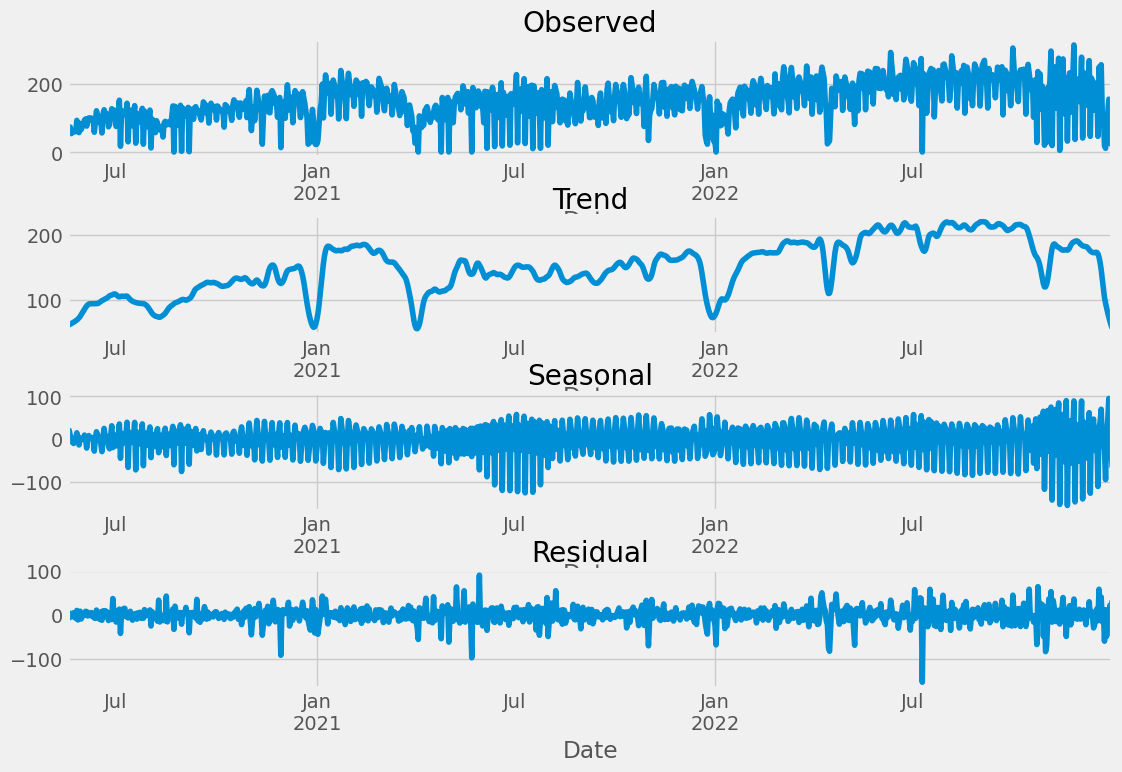

In [25]:
# Plot the components
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_title('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_title('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_title('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_title('Residual')

plt.show()

We can see from the time series decomposition that it has no uptrend, it has some seasonality, and a fairly strong residual component. Now we proceed to detect and handle outlier values.

## Outlier Analysis, Detection and Handling

For handling outliers, I have chosen to apply **winsorizetion**, wherein the patient arrival counts that are above the set upper bound, and below the set lower bound will be adjusted to stay within the bounds.

In [26]:
## Calculate the IQR and bounds
Q1 = patients_series.quantile(0.25)
Q3 = patients_series.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 0.1 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Lower Bound: {lower_bound}')
print(f'Upper Bound: {upper_bound}')

Lower Bound: 106.2
Upper Bound: 309.0


The lower bound is set to 106.2, while the upper bound is set to 309. This means that any patient arrival counts that are less than 106.2 or greater than 309 are adjusted to have these values.

We can also see that a greater weight was assigned to the Upper bound. This is due to my assumption that there is a greater need to be informed at times when patient arrival counts will be at their peaks, as opposed to times when the patient arrival counts would be at their lowest counts.

In [27]:
def custom_winsorize(x):
    if x < lower_bound:
        return lower_bound
    elif x > upper_bound:
        return upper_bound
    else:
        return x

cleaned_series = patients_series.copy()
cleaned_series = cleaned_series.apply(custom_winsorize)
df['Patients'] = cleaned_series.copy()

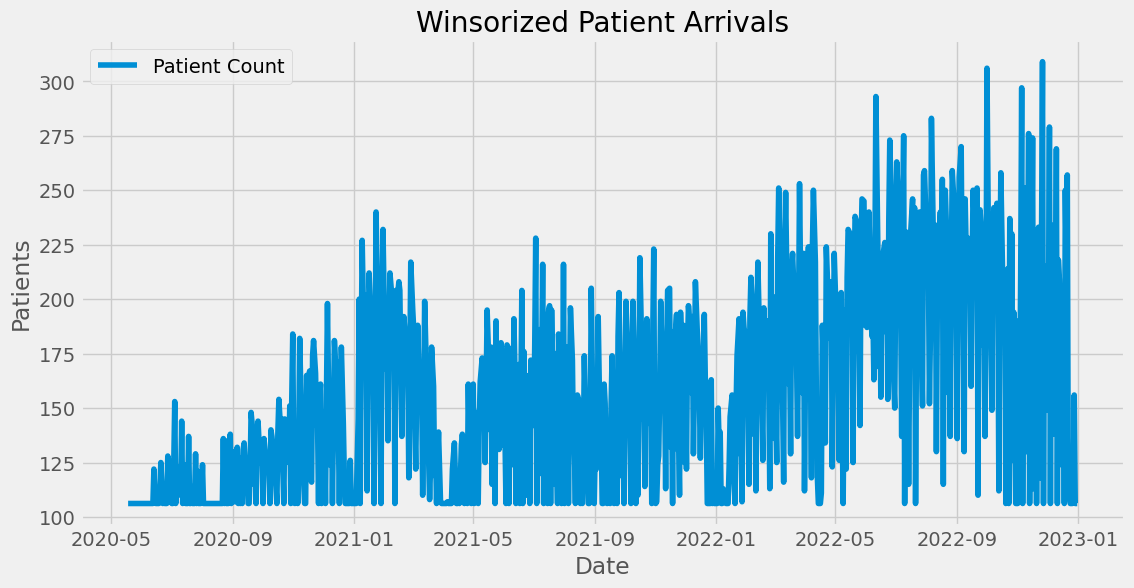

In [28]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the winsorized patient arrivals data
ax.plot(df.index, df['Patients'], label='Patient Count')

# Set the title and labels for the plot
ax.set_title('Winsorized Patient Arrivals')
ax.set_xlabel('Date')
ax.set_ylabel('Patients')

# Show the legend
ax.legend()

# Display the plot
plt.show()

Now we have our winsorized time series data. In order to have a better chance of improving our forecating model, let's proceed to **Feature Engineering**.

## Feature Engineering

**Feature Engineering** is a way to enrich the data. It essentially means that we will do a series of additional calculations with the goal of improving model performance, and to find out which features are the most effective in giving out predictions.

Since we have time series data here, we generate time series features and add rolling statistics as well.

In [29]:
def create_features(df, label=None):
    """
    Create time series features from the datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    
    window_size = 7  # 7-day rolling window
    
    # Rolling sum
    df['rolling_sum'] = df['Patients'].rolling(window=window_size).sum()

    # Rolling mean
    df['rolling_mean'] = df['Patients'].rolling(window=window_size).mean()

    # Rolling median
    df['rolling_median'] = df['Patients'].rolling(window=window_size).median()

    # Rolling standard deviation
    df['rolling_std'] = df['Patients'].rolling(window=window_size).std()

    # Rolling quantile (25th percentile)
    quantile_25 = 0.25
    df['rolling_quantile_25'] = df['Patients'].rolling(window=window_size).quantile(quantile_25)

    # Rolling quantile (75th percentile)
    quantile_75 = 0.75
    df['rolling_quantile_75'] = df['Patients'].rolling(window=window_size).quantile(quantile_75)

    return df

df = create_features(df)

In [30]:
df.dtypes

Patients                      float64
date                   datetime64[ns]
day_of_week                     int32
month                           int32
day_of_year                     int32
rolling_sum                   float64
rolling_mean                  float64
rolling_median                float64
rolling_std                   float64
rolling_quantile_25           float64
rolling_quantile_75           float64
dtype: object

In [31]:
df.head()

Patients       date  day_of_week  month  day_of_year  rolling_sum  \
Date                                                                            
2020-05-18     106.2 2020-05-18            0      5          139          NaN   
2020-05-19     106.2 2020-05-19            1      5          140          NaN   
2020-05-20     106.2 2020-05-20            2      5          141          NaN   
2020-05-21     106.2 2020-05-21            3      5          142          NaN   
2020-05-22     106.2 2020-05-22            4      5          143          NaN   

            rolling_mean  rolling_median  rolling_std  rolling_quantile_25  \
Date                                                                         
2020-05-18           NaN             NaN          NaN                  NaN   
2020-05-19           NaN             NaN          NaN                  NaN   
2020-05-20           NaN             NaN          NaN                  NaN   
2020-05-21           NaN             NaN          NaN                  NaN   
2020-05-22           NaN             NaN          NaN                  NaN   

            rolling_quantile_75  
Date                             
2020-05-18                  NaN  
2020-05-19                  NaN  
2020-05-20                  NaN  
2020-05-21                  NaN  
2020-05-22                  NaN

Now that we have generated time series features, let's first have a look on how cross-validation works with time series.

## Time Series Cross-Validation

We use a **Sliding Window Cross-Validation** technique here wherein we ensure that none of the information about the future is fed into model while training, and we give the model observations about something that it shouldn't have seen at that moment in time. We test the model right after a training period finishes.

In [32]:
from sklearn.model_selection import TimeSeriesSplit

In [33]:
tss = TimeSeriesSplit(n_splits=8, test_size=119, gap=1)
df = df.sort_index()

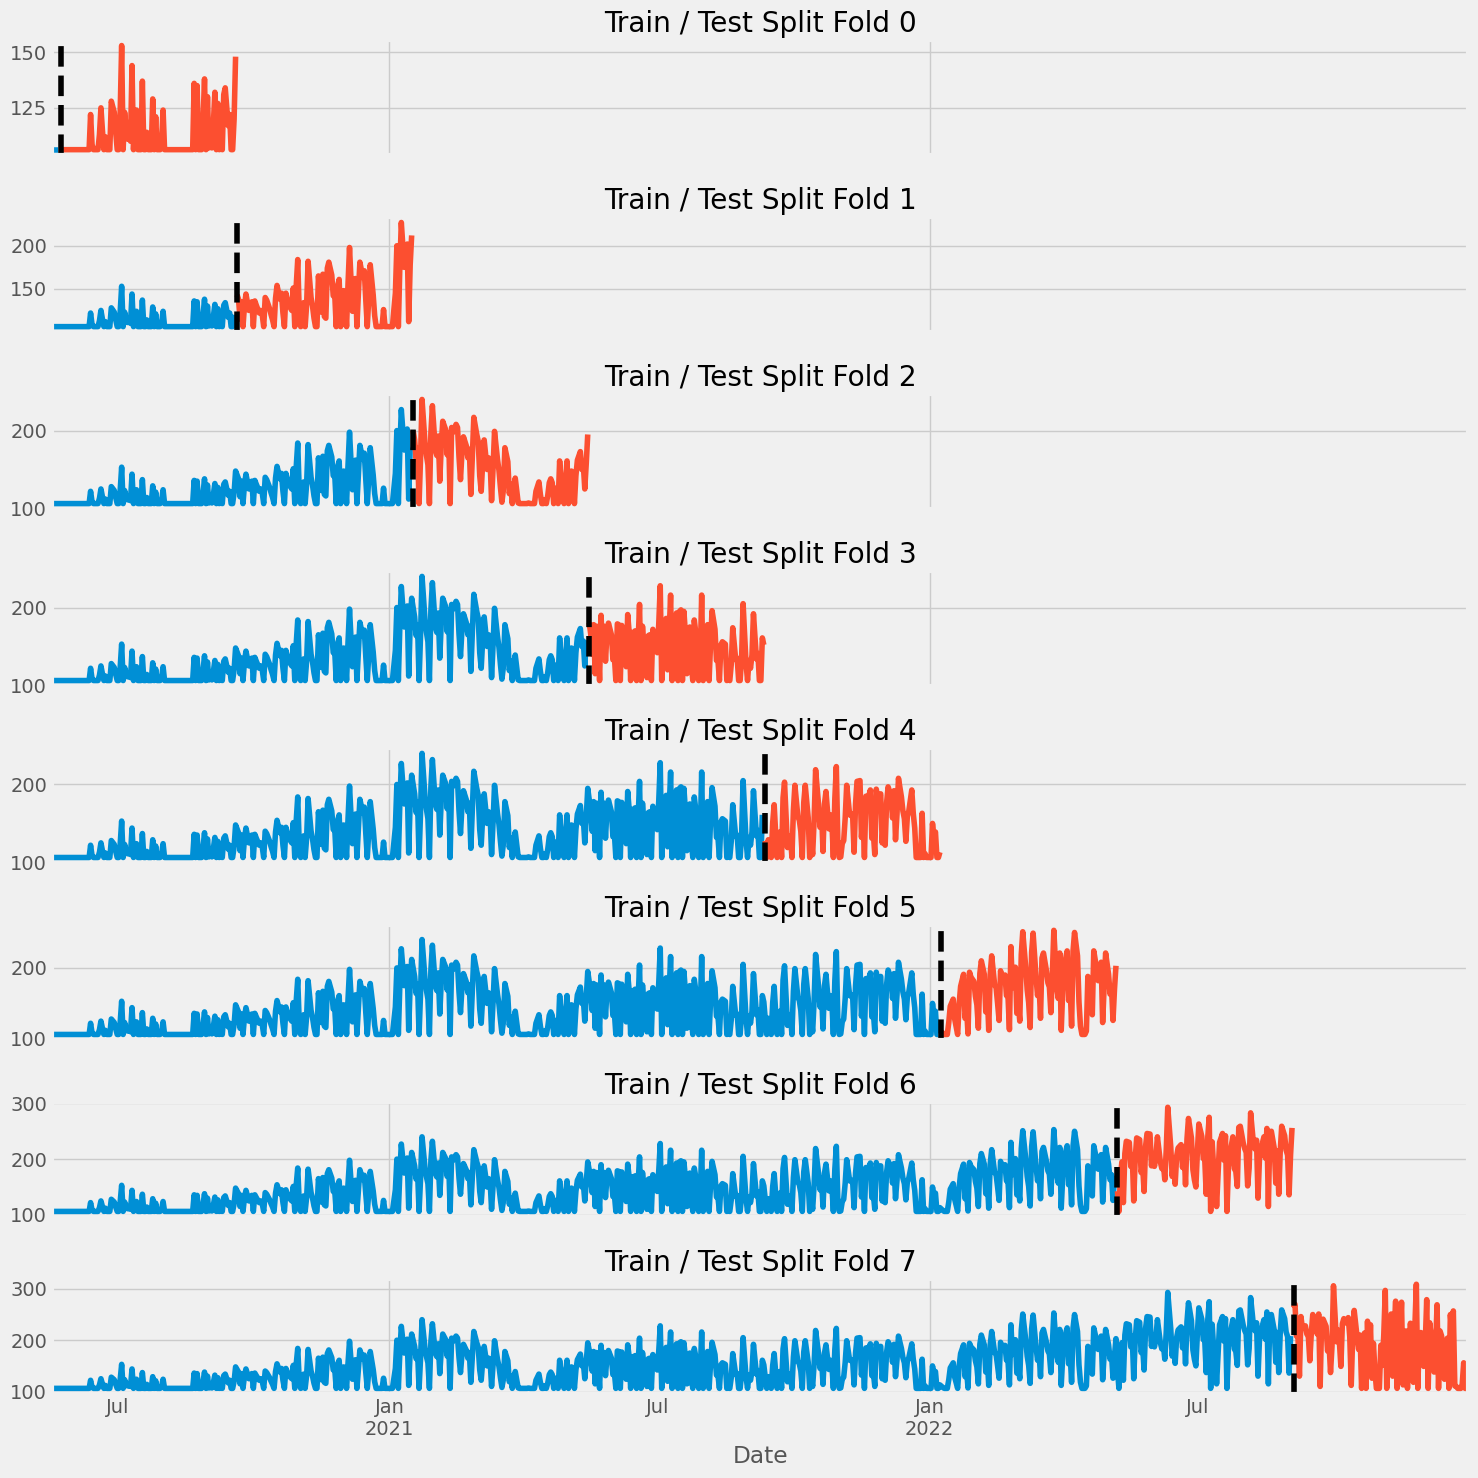

In [34]:
fig, axs = plt.subplots(8, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]
    train['Patients'].plot(ax=axs[fold],
                           label='Training Set',
                           title=f'Train / Test Split Fold {fold}')
    test['Patients'].plot(ax=axs[fold], label='Test Set')
    
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.tight_layout()
plt.show()

In this case, we choose an **8-fold Sliding Window Cross-Validation** technique for our time series data.

## Forecasting horizon

### Lag features

Adding lag features for time series forecasting models is essential, especially for models that aren't specialized for dealing with time series data. They are used to help the forecasting model learn about the temporal structure and historical values.

In [35]:
def add_lags(df):
    target_map = df['Patients'].to_dict()
    df['lag_7_days'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag_14_days'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag_21_days'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    df['lag_28_days'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag_30_days'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag_60_days'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['lag_180_days'] = (df.index - pd.Timedelta('180 days')).map(target_map)
    return df

df = add_lags(df)

In [36]:
df.head()

Patients       date  day_of_week  month  day_of_year  rolling_sum  \
Date                                                                            
2020-05-18     106.2 2020-05-18            0      5          139          NaN   
2020-05-19     106.2 2020-05-19            1      5          140          NaN   
2020-05-20     106.2 2020-05-20            2      5          141          NaN   
2020-05-21     106.2 2020-05-21            3      5          142          NaN   
2020-05-22     106.2 2020-05-22            4      5          143          NaN   

            rolling_mean  rolling_median  rolling_std  rolling_quantile_25  \
Date                                                                         
2020-05-18           NaN             NaN          NaN                  NaN   
2020-05-19           NaN             NaN          NaN                  NaN   
2020-05-20           NaN             NaN          NaN                  NaN   
2020-05-21           NaN             NaN          NaN                  NaN   
2020-05-22           NaN             NaN          NaN                  NaN   

            rolling_quantile_75  lag_7_days  lag_14_days  lag_21_days  \
Date                                                                    
2020-05-18                  NaN         NaN          NaN          NaN   
2020-05-19                  NaN         NaN          NaN          NaN   
2020-05-20                  NaN         NaN          NaN          NaN   
2020-05-21                  NaN         NaN          NaN          NaN   
2020-05-22                  NaN         NaN          NaN          NaN   

            lag_28_days  lag_30_days  lag_60_days  lag_180_days  
Date                                                             
2020-05-18          NaN          NaN          NaN           NaN  
2020-05-19          NaN          NaN          NaN           NaN  
2020-05-20          NaN          NaN          NaN           NaN  
2020-05-21          NaN          NaN          NaN           NaN  
2020-05-22          NaN          NaN          NaN           NaN

In [37]:
df.dtypes

Patients                      float64
date                   datetime64[ns]
day_of_week                     int32
month                           int32
day_of_year                     int32
rolling_sum                   float64
rolling_mean                  float64
rolling_median                float64
rolling_std                   float64
rolling_quantile_25           float64
rolling_quantile_75           float64
lag_7_days                    float64
lag_14_days                   float64
lag_21_days                   float64
lag_28_days                   float64
lag_30_days                   float64
lag_60_days                   float64
lag_180_days                  float64
dtype: object

## Model Building

Now that we have finished feature engineering and added time lags, it is now time to build the forecasting model. The forecasting model we're about to use is known as **eXtreme Gradient Boosting** (XGBoost).

XGBoost is a powerful machine learning algorithm that is widely used for various predictive modeling tasks, including time series forecasting.
Here's how it works:

- **Boosting Superpower**: XGBoost is like having a team of very smart experts. Each expert (or "weak learner") tries to understand the patterns in your data. They start by making a guess, and they might not be very good at it initially.
    
- **Learning from Mistakes**: XGBoost doesn't give up easily. It looks at where each expert made mistakes and focuses more on the areas where they need improvement. This way, they learn from their mistakes and get better with each try.
    
- **Combining Expert Opinions**: After multiple rounds of learning and improving, XGBoost combines the opinions of all the experts to make a final prediction. It's like getting advice from a group of specialists who have become really good at understanding your data.
    
- **Making Accurate Predictions**: The combined prediction is usually very accurate because it's based on the collective wisdom of the experts who have learned from their mistakes. This helps you forecast future values in your time series data with high precision.
    

So, why is XGBoost great for time series forecasting?

- **Handles Complex Patterns**: Time series data often has intricate patterns, like seasonal trends or irregular fluctuations. XGBoost excels at capturing these patterns, even when they're not straightforward.
    
- **Robust to Noise**: In real-world data, there can be noise or randomness that makes predictions challenging. XGBoost is robust and can filter out the noise to focus on the important signals.
    
- **Flexibility**: It's flexible and can be used for various types of time series data, whether you're predicting sales, energy consumption, or anything else that changes over time.
    
- **Automatic Feature Engineering**: XGBoost can automatically find the most important features or factors affecting your predictions, saving you a lot of manual work.
    

In a nutshell, XGBoost is your reliable partner for time series forecasting. It's like having a team of experts who learn from their mistakes and work together to make highly accurate predictions from your historical data. It's a valuable tool for making informed decisions and planning for the future.


## Train Using Time Series Cross-Validation

Before training our model, we first define the metrics we will use to measure model performance.

In [38]:
# Define the error metrics

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

In [39]:
df.columns

Index(['Patients', 'date', 'day_of_week', 'month', 'day_of_year',
       'rolling_sum', 'rolling_mean', 'rolling_median', 'rolling_std',
       'rolling_quantile_25', 'rolling_quantile_75', 'lag_7_days',
       'lag_14_days', 'lag_21_days', 'lag_28_days', 'lag_30_days',
       'lag_60_days', 'lag_180_days'],
      dtype='object')

In [40]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=8, test_size=119, gap=1)
df = df.sort_index()

fold = 0
preds = []

rmse_scores = []
mape_scores = []
smape_scores = []

# Initialize an empty DataFrame to store actual and predicted values
actual_vs_pred_df = pd.DataFrame()

for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['day_of_week', 'month', 'day_of_year', 'rolling_sum', 'rolling_mean', 
                'rolling_median', 'rolling_std', 'rolling_quantile_25', 'rolling_quantile_75', 
                'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days', 'lag_30_days',
                'lag_60_days', 'lag_180_days']

    TARGET = 'Patients'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=900, 
                           early_stopping_rounds=50, 
                           tree_method='hist',
                           objective='reg:squarederror', 
                           max_depth=3, 
                           min_child_weight=3, 
                           gamma=0, 
                           learning_rate=0.01, 
                           colsample_bytree=0.9, 
                           subsample=0.7,
                           reg_lambda=0)
    
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    
    rmse = root_mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)
    
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    smape_scores.append(smape)
    
    # Store actual and predicted values along with their datetime index in the DataFrame
    temp_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred}, index=df.iloc[val_index].index)
    actual_vs_pred_df = pd.concat([actual_vs_pred_df, temp_df])

[0]	validation_0-rmse:104.64300	validation_1-rmse:111.40761
[100]	validation_0-rmse:39.08043	validation_1-rmse:46.54263
[200]	validation_0-rmse:14.44920	validation_1-rmse:23.20963
[300]	validation_0-rmse:5.50580	validation_1-rmse:15.74851
[400]	validation_0-rmse:2.09799	validation_1-rmse:13.39210
[500]	validation_0-rmse:0.77570	validation_1-rmse:12.60788
[600]	validation_0-rmse:0.29858	validation_1-rmse:12.34747
[700]	validation_0-rmse:0.11038	validation_1-rmse:12.24834
[800]	validation_0-rmse:0.04039	validation_1-rmse:12.21201
[899]	validation_0-rmse:0.01495	validation_1-rmse:12.19888
[0]	validation_0-rmse:110.69352	validation_1-rmse:139.11117
[100]	validation_0-rmse:40.83041	validation_1-rmse:62.69965
[200]	validation_0-rmse:15.50898	validation_1-rmse:35.77064
[300]	validation_0-rmse:6.56347	validation_1-rmse:27.42417
[400]	validation_0-rmse:3.77385	validation_1-rmse:25.35646
[500]	validation_0-rmse:2.86891	validation_1-rmse:24.74707
[600]	validation_0-rmse:2.47277	validation_1-rmse:

## Model Evaluation

In [41]:
# Print the results
print(f'RMSE across folds: {np.mean(rmse_scores):.3f}')
print(f'MAPE across folds: {np.mean(mape_scores):.3f}%')
print(f'sMAPE across folds: {np.mean(smape_scores):.3f}%')

RMSE across folds: 24.618
MAPE across folds: 11.753%
sMAPE across folds: 11.629%


It seems like we were able to generate errors with 11% margin of error. I can say that this would be satifactory, but let's see how it looks by visualizing the predictions

In [42]:
# Display the DataFrame
actual_vs_pred_df.tail()

Actual   Predicted
Date                          
2022-12-27   114.0  119.435753
2022-12-28   156.0  129.489410
2022-12-29   106.2  106.259026
2022-12-30   106.2  107.986107
2022-12-31   106.2  136.364975

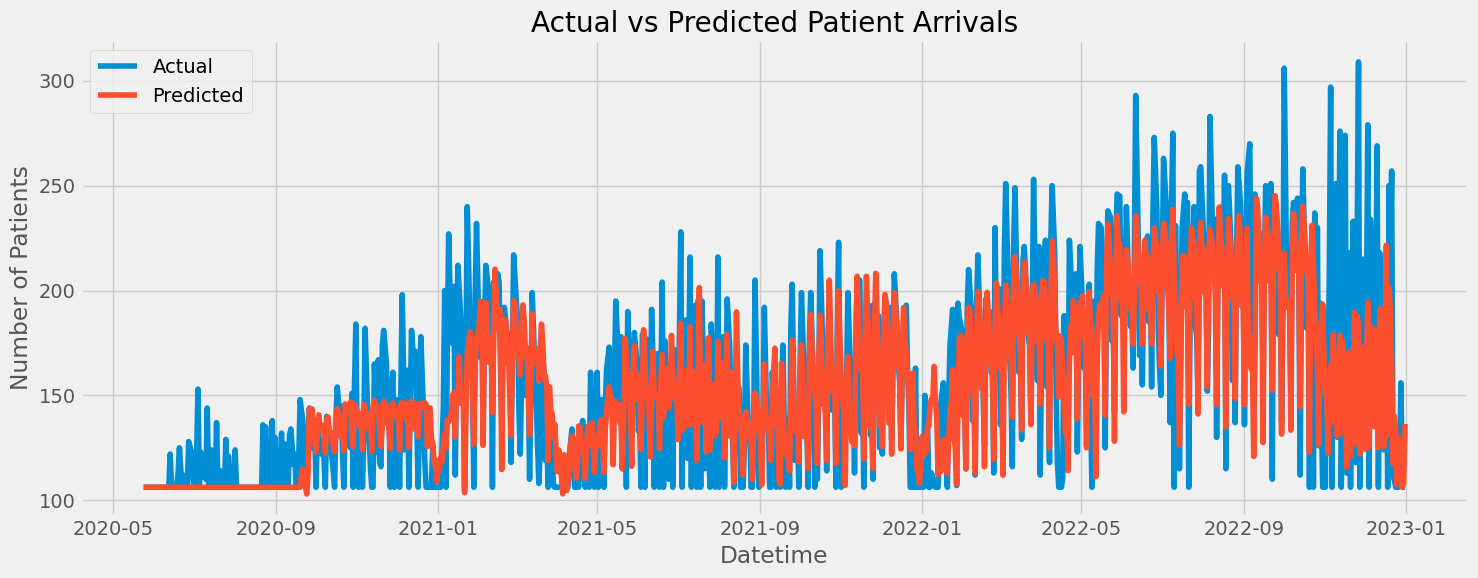

In [43]:
plt.figure(figsize=(15, 6))
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Actual'], label='Actual')
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Predicted'], label='Predicted')

plt.xlabel('Datetime')
plt.ylabel('Number of Patients')
plt.title('Actual vs Predicted Patient Arrivals')
plt.legend()

plt.tight_layout()
plt.show()

The predictions start of as bad, but it has started to follow the pattern around the year of 2021, and has been performing quite well as the time goes on. Now that we have been able to test our model, it is now time to generate forecasts for the future.

## Preparing to Predict the Future

But before we actually generate future forecasts, we first retrain the model.

In [44]:
# Retrain on all data
df = create_features(df)

FEATURES = ['day_of_week', 'month', 'day_of_year', 'rolling_sum', 'rolling_mean', 
                'rolling_median', 'rolling_std', 'rolling_quantile_25', 'rolling_quantile_75', 
                'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days', 'lag_30_days',
                'lag_60_days', 'lag_180_days']


TARGET = 'Patients'

X_all = df[FEATURES]
y_all = df[TARGET]
    

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=900, 
                       early_stopping_rounds=50, 
                       tree_method='hist',
                       objective='reg:squarederror', 
                       max_depth=3, 
                       min_child_weight=3, 
                       gamma=0, 
                       learning_rate=0.01, 
                       colsample_bytree=0.9, 
                       subsample=0.7,
                       reg_lambda=0)
    
reg.fit(X_all, y_all, eval_set=[(X_all, y_all)],
       verbose=100)

[0]	validation_0-rmse:163.01014
[100]	validation_0-rmse:63.17849
[200]	validation_0-rmse:29.72110
[300]	validation_0-rmse:20.40659
[400]	validation_0-rmse:17.90128
[500]	validation_0-rmse:16.78217
[600]	validation_0-rmse:15.96184
[700]	validation_0-rmse:15.29489
[800]	validation_0-rmse:14.71951
[899]	validation_0-rmse:14.20462


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [45]:
df.index.max()

Timestamp('2022-12-31 00:00:00')

We then try to know the latest date and then create a date range for a new DataFrame starting from that date onto the future. For this case, I create a forecast for up to 6 months

In [46]:
# Create future DataFrame
future = pd.date_range('2022-12-31', '2023-06-28', freq='D')
future_df = pd.DataFrame(index=future)

future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [47]:
future_with_features = df_and_future.query('isFuture').copy()

In [48]:
future_with_features.head()

Patients       date  day_of_week  month  day_of_year  rolling_sum  \
2022-12-31       NaN 2022-12-31            5     12          365          NaN   
2023-01-01       NaN 2023-01-01            6      1            1          NaN   
2023-01-02       NaN 2023-01-02            0      1            2          NaN   
2023-01-03       NaN 2023-01-03            1      1            3          NaN   
2023-01-04       NaN 2023-01-04            2      1            4          NaN   

            rolling_mean  rolling_median  rolling_std  rolling_quantile_25  \
2022-12-31           NaN             NaN          NaN                  NaN   
2023-01-01           NaN             NaN          NaN                  NaN   
2023-01-02           NaN             NaN          NaN                  NaN   
2023-01-03           NaN             NaN          NaN                  NaN   
2023-01-04           NaN             NaN          NaN                  NaN   

            rolling_quantile_75  lag_7_days  lag_14_days  lag_21_days  \
2022-12-31                  NaN       106.2        204.0        269.0   
2023-01-01                  NaN       106.2        106.2        106.2   
2023-01-02                  NaN       106.2        250.0        218.0   
2023-01-03                  NaN       114.0        214.0        209.0   
2023-01-04                  NaN       156.0        257.0        190.0   

            lag_28_days  lag_30_days  lag_60_days  lag_180_days  isFuture  
2022-12-31        279.0        149.0        106.2         241.0      True  
2023-01-01        106.2        191.0        190.0         201.0      True  
2023-01-02        234.0        279.0        151.0         200.0      True  
2023-01-03        210.0        106.2        211.0         137.0      True  
2023-01-04        183.0        234.0        297.0         238.0      True

In [49]:
future_with_features.tail()

Patients       date  day_of_week  month  day_of_year  rolling_sum  \
2023-06-24       NaN 2023-06-24            5      6          175          NaN   
2023-06-25       NaN 2023-06-25            6      6          176          NaN   
2023-06-26       NaN 2023-06-26            0      6          177          NaN   
2023-06-27       NaN 2023-06-27            1      6          178          NaN   
2023-06-28       NaN 2023-06-28            2      6          179          NaN   

            rolling_mean  rolling_median  rolling_std  rolling_quantile_25  \
2023-06-24           NaN             NaN          NaN                  NaN   
2023-06-25           NaN             NaN          NaN                  NaN   
2023-06-26           NaN             NaN          NaN                  NaN   
2023-06-27           NaN             NaN          NaN                  NaN   
2023-06-28           NaN             NaN          NaN                  NaN   

            rolling_quantile_75  lag_7_days  lag_14_days  lag_21_days  \
2023-06-24                  NaN         NaN          NaN          NaN   
2023-06-25                  NaN         NaN          NaN          NaN   
2023-06-26                  NaN         NaN          NaN          NaN   
2023-06-27                  NaN         NaN          NaN          NaN   
2023-06-28                  NaN         NaN          NaN          NaN   

            lag_28_days  lag_30_days  lag_60_days  lag_180_days  isFuture  
2023-06-24          NaN          NaN          NaN         106.2      True  
2023-06-25          NaN          NaN          NaN         114.0      True  
2023-06-26          NaN          NaN          NaN         156.0      True  
2023-06-27          NaN          NaN          NaN         106.2      True  
2023-06-28          NaN          NaN          NaN         106.2      True

## Feature Importance

With feature importance, we are able to know which features were proven to be the most effective for improving the model performance of the XGBoost model.

In [50]:
feature_importance = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
feature_importance

importance
day_of_week            0.026455
month                  0.011702
day_of_year            0.020179
rolling_sum            0.091566
rolling_mean           0.079365
rolling_median         0.066245
rolling_std            0.021650
rolling_quantile_25    0.046967
rolling_quantile_75    0.042492
lag_7_days             0.359323
lag_14_days            0.113579
lag_21_days            0.038001
lag_28_days            0.031414
lag_30_days            0.019930
lag_60_days            0.013976
lag_180_days           0.017154

<Axes: title={'center': 'Feature Importance'}>

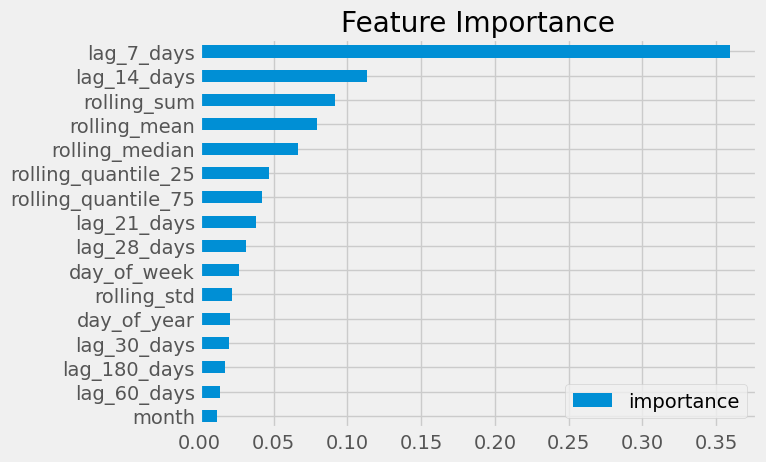

In [51]:
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')

It seems like the 7-day lag feature has proven to be the most effective for our forecasting model. This just proves that lags are a very essential feature for time series forecasting.

## Predict the future

Now is the time to generate future forecasts of patient arrivals per day.

In [52]:
future_with_features['pred'] = reg.predict(future_with_features[FEATURES])

In [53]:
future_with_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180 entries, 2022-12-31 to 2023-06-28
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Patients             0 non-null      float64       
 1   date                 180 non-null    datetime64[ns]
 2   day_of_week          180 non-null    int32         
 3   month                180 non-null    int32         
 4   day_of_year          180 non-null    int32         
 5   rolling_sum          0 non-null      float64       
 6   rolling_mean         0 non-null      float64       
 7   rolling_median       0 non-null      float64       
 8   rolling_std          0 non-null      float64       
 9   rolling_quantile_25  0 non-null      float64       
 10  rolling_quantile_75  0 non-null      float64       
 11  lag_7_days           7 non-null      float64       
 12  lag_14_days          14 non-null     float64       
 13  lag_21_days     

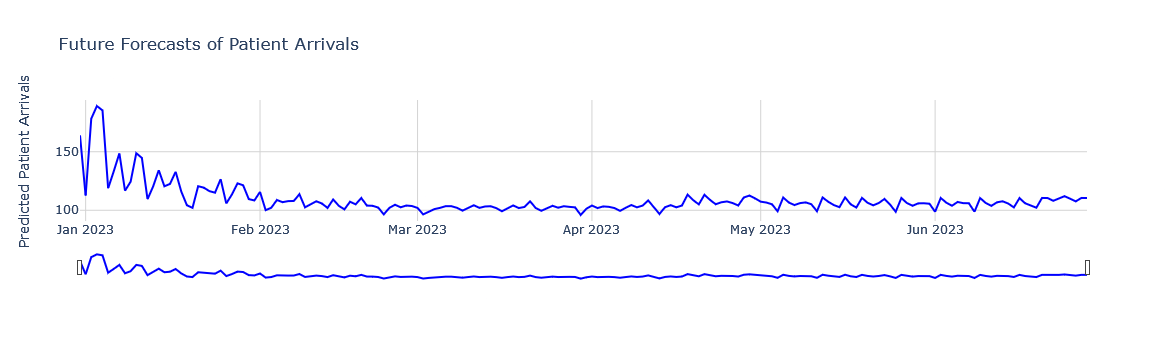

In [54]:
# Create a new figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=future_with_features.index, y=future_with_features['pred'],
                         name='Predicted Patient Arrivals',
                         line=dict(color='blue', width=2),
                         hovertemplate='<b>Date</b>: %{x|%m-%d-%Y}<br>' +
                                       '<b>Patients</b>: %{y}<br>' +
                                       '<b>Day of Week</b>: %{x| %A}<extra></extra>'))

fig.update_layout(
    title='Future Forecasts of Patient Arrivals',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis_title='Predicted Patient Arrivals',
    template='plotly_white'
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.show()

And there we have it, we have finally generated future forecasts of patient arrivals.

## Save the model

Now we can save this model so that it can be deployed into production.

In [55]:
# Save the model
reg.save_model('forecast-models/xgboost_model_2.json')

## References

- Rob Mulla. (2022, August 7). _Time Series Forecasting with XGBoost - Advanced Methods_ [Video]. YouTube. https://www.youtube.com/watch?v=z3ZnOW-S550
- Robikscube. (2022, August 1). _PT2: Time Series Forecasting with XGBoost_. Kaggle. https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook